# Part 1: Feature extraction

## Initial Setup

In [9]:
import numpy as np
import tensorflow as tf
import utils
from vgg import Vgg16
%matplotlib inline
%load_ext autoreload
%autoreload 2

def get_session(graph):
    """
    Create a session that dynamically allocates memory.
    """
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config, graph=graph)
    return session

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Location of the pretrained weights
- Downloaded from http://www.robots.ox.ac.uk/~vgg/software/vgg_face/
- Converted from Caffe model to .npy using https://github.com/ethereon/caffe-tensorflow

In [2]:
pretrained_weights = './vgg_face_caffe/vgg16.npy'

## Load image paths and labels

In [3]:
from collections import Counter
X_train, Y_train = utils.get_data(utils.TRAIN_SET)
X_val, Y_val = utils.get_data(utils.VAL_SET)
print('[INFO] Number of training samples: {}'.format(len(Y_train)))
train_stats = Counter(Y_train)
print('Male: {} ; Female : {}'.format(train_stats[0], train_stats[1]))
print('[INFO] Number of validation samples: {}'.format(len(Y_val)))
val_stats = Counter(Y_val)
print('Male: {} ; Female : {}'.format(val_stats[0], val_stats[1]))
train_data = dict(zip(X_train, Y_train))
val_data = dict(zip(X_val, Y_val))

[INFO] Number of training samples: 11162
Male: 5065 ; Female : 6097
[INFO] Number of validation samples: 2398
Male: 1138 ; Female : 1260


## Extract fc6 and fc7 features from the images
###### **NOTE:** Taken a subset of the dataset due to limited compute

In [4]:
tiny = 4000
bs = 32
graph = tf.Graph()
with graph.as_default():
    # Create session
    sess = get_session(graph=graph)
    # Initialize model
    model = Vgg16(pretrained=pretrained_weights, sess=sess)
    init = tf.global_variables_initializer()
    with tf.device('/cpu:0'):
        sess.run(init)
        model.load_weights(pretrained_weights, sess)
        _, fc7_train_data = model.extract_features(X_train[:tiny], sess, batch_size=bs)
        _, fc7_val_data = model.extract_features(X_val[:tiny//4], sess, batch_size=bs)
        # fc6_train_data, fc7_train_data = model.extract_features(X_train[:tiny], sess, batch_size=bs)
        # fc6_val_data, fc7_val_data = model.extract_features(X_val[:tiny//4], sess, batch_size=bs)

[INFO] Loaded pretrained weights from ./vgg_face_caffe/vgg16.npy
[INFO] Extracting features for 125 batches


/Users/sanyam/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[INFO] Extracted from mini-batch 1 / 125 at 0.82s per image
[INFO] Extracted from mini-batch 5 / 125 at 0.83s per image
[INFO] Extracted from mini-batch 10 / 125 at 0.93s per image
[INFO] Extracted from mini-batch 15 / 125 at 1.22s per image
[INFO] Extracted from mini-batch 20 / 125 at 0.85s per image
[INFO] Extracted from mini-batch 25 / 125 at 0.83s per image
[INFO] Extracted from mini-batch 30 / 125 at 0.83s per image
[INFO] Extracted from mini-batch 35 / 125 at 0.82s per image
[INFO] Extracted from mini-batch 40 / 125 at 0.86s per image
[INFO] Extracted from mini-batch 45 / 125 at 0.86s per image
[INFO] Extracted from mini-batch 50 / 125 at 0.91s per image
[INFO] Extracted from mini-batch 55 / 125 at 0.83s per image
[INFO] Extracted from mini-batch 60 / 125 at 1.41s per image
[INFO] Extracted from mini-batch 65 / 125 at 0.95s per image
[INFO] Extracted from mini-batch 70 / 125 at 1.08s per image
[INFO] Extracted from mini-batch 75 / 125 at 0.92s per image
[INFO] Extracted from mini

In [6]:
for k, v in fc7_train_data.items():
    print('SAMPLE:\n\nPath: {}\n\nFeatures: {}\n\nShape: {}\n'.format(k, v, v.shape))
    10*'='
    break

smallest = float('Inf')
for v in fc7_train_data.values():
    smallest = min(smallest, min(v))
print('Min value: {}'.format(smallest))

largest = float('-Inf')
for v in fc7_train_data.values():
    largest = max(largest, max(v))
print('Max value: {}'.format(largest))

SAMPLE:

Path: ./Data/aligned/30601258@N03/landmark_aligned_face.2.9347736083_92e9eedef9_o.jpg

Features: [ -5.84495497 -33.51340485  -3.96308708 ..., -25.0749855  -16.17303467
 -15.72397804]

Shape: (4096,)

Min value: -110.22330474853516
Max value: 63.859771728515625


## Save features for loading later

In [7]:
save_file_train = 'fc7_train_feats_large.npy'
np.save(save_file_train, fc7_train_data)

save_file_val = 'fc7_val_feats_large.npy'
np.save(save_file_val, fc7_val_data)

## Load and sanity check

In [8]:
fc7_train_loaded = np.load(save_file_train)[()]
fc7_val_loaded = np.load(save_file_val)[()]


for k, v in fc7_train_loaded.items():
    print('SAMPLE:\n\nPath: {}\n\nFeatures: {}\n\nShape: {}\n'.format(k, v, v.shape))
    10*'='
    break

smallest = float('Inf')
for v in fc7_train_loaded.values():
    smallest = min(smallest, min(v))
print('Min value: {}'.format(smallest))

largest = float('-Inf')
for v in fc7_train_loaded.values():
    largest = max(largest, max(v))
print('Max value: {}'.format(largest))

SAMPLE:

Path: ./Data/aligned/30601258@N03/landmark_aligned_face.2.9347736083_92e9eedef9_o.jpg

Features: [ -5.84495497 -33.51340485  -3.96308708 ..., -25.0749855  -16.17303467
 -15.72397804]

Shape: (4096,)

Min value: -110.22330474853516
Max value: 63.859771728515625


# Part 2: Transfer Learning

## Data prep
Note: Should be avoided by using proper output format

In [10]:

# fc6_X_train = np.array([v for _, v in fc6_train_data.items()])
# fc6_Y_train = np.array([train_data[k] for k, _ in fc6_train_data.items()])

# fc6_X_val = np.array([v for _, v in fc6_val_data.items()])
# fc6_Y_val = np.array([val_data[k] for k, _ in fc6_val_data.items()])

fc7_X_train = np.array([v for _, v in fc7_train_loaded.items()])
fc7_Y_train = np.array([train_data[k] for k, _ in fc7_train_loaded.items()])

fc7_X_val = np.array([v for _, v in fc7_val_loaded.items()])
fc7_Y_val = np.array([val_data[k] for k, _ in fc7_val_loaded.items()])

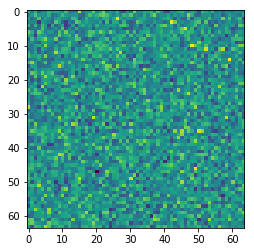

In [11]:
import matplotlib.pyplot as plt
a = fc7_X_train[0]
np.shape(a)
aa = np.reshape(a, [-1, 64])
plt.imshow(aa)
plt.show()

## Define classifier

In [44]:
class Classifier():
    
    def __init__(self, params):
        # Placeholders and other setup
        self.feats = tf.placeholder(tf.float32, [None, 4096])
        self.drop_placeholder = tf.placeholder(tf.float32, ())
        self.labels = tf.placeholder(tf.int64, [None])
        self.training = tf.placeholder(tf.bool)
        
        # Create the ops
        self._make_layers()
        self._add_loss_op()
        self._add_correct_preds_op()
        self._add_accuracy_op()
        self._add_train_op()
        
        self.saver = tf.train.Saver()

    def _make_layers(self):
        # Setup hidden layer
        with tf.variable_scope('hidden_layer') as scope:
            # initialize weights
            weights = tf.get_variable(name='weights',
                shape=[4096, params['hidden_dim']],
                initializer=tf.contrib.layers.xavier_initializer(),
                trainable=True)
            # initialize biases
            biases = tf.get_variable(name='biases',
                shape=[params['hidden_dim']],
                initializer=tf.constant_initializer(0.0),
                trainable=True)

            h_out = tf.matmul(tf.nn.relu(self.feats), weights)
            h_out = tf.contrib.layers.batch_norm(inputs=h_out,
                                               center=True,
                                               scale=True,
                                               is_training=self.training)
            h_out = tf.nn.bias_add(h_out, biases)
            h_out = tf.nn.relu(h_out)

            h_out = tf.nn.dropout(h_out, keep_prob=self.drop_placeholder)


        # Setup classifier
        with tf.variable_scope('classifier') as scope:
            # initialize weights
            weights = tf.get_variable(name='weights',
                shape=[params['hidden_dim'], 2],
                initializer=tf.contrib.layers.xavier_initializer(),
                trainable=True)
            # initialize biases
            biases = tf.get_variable(name='biases',
                shape=[2],
                initializer=tf.constant_initializer(0.0),
                trainable=True)
            logits = tf.matmul(h_out, weights)
            self.logits = tf.nn.bias_add(logits, biases)

    def _add_loss_op(self):
        # Add loss op
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.labels, 2), logits=self.logits))

    def _add_train_op(self):
        # Add optimizer op
        self.train_op = tf.train.AdamOptimizer(learning_rate=params['lr']).minimize(self.loss)

    def _add_correct_preds_op(self):
        self.correct_preds = tf.equal(tf.argmax(self.logits, axis=1), self.labels)

    def _add_accuracy_op(self):
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_preds, tf.float32))

    def _run_epoch(self, session, X, Y, is_train=True):
        # Record losses and accuracy per mini-batch
        mini_batch_losses = []
        correct, total_count = 0, 0

        # Randomize order of data
        train_indices = np.arange(Y.shape[0])
        np.random.shuffle(train_indices)

        # Run the epoch
        for mini_batch in range(int(np.ceil(Y.shape[0] / params['bs']))):
            start_idx = (mini_batch * params['bs']) % Y.shape[0]
            idx = train_indices[start_idx:start_idx + params['bs']]
            # Get actual batch size
            actual_batch_size = Y[mini_batch:mini_batch + params['bs']].shape[0]
            total_count += actual_batch_size
            # Create input and output feed for mini-batch
            if is_train:
                input_feed = {self.feats: X[idx, :],
                              self.labels: Y[idx],
                              self.drop_placeholder: params['keep_prob'],
                              self.training: True}
                output_feed = [self.loss, self.correct_preds, self.train_op]
                loss, correct_pred, _ = session.run(output_feed, input_feed)
            else:
                # TODO: Use acc to verify accuracy numbers
                input_feed = {self.feats: X[idx, :],
                              self.labels: Y[idx],
                              self.drop_placeholder: 1.0,
                              self.training: False}
                output_feed = [self.loss, self.correct_preds, self.accuracy]
                loss, correct_pred, acc = session.run(output_feed, input_feed)
            mini_batch_losses.append(loss * actual_batch_size)
            correct += np.sum(correct_pred)
            if params['print_every'] > 0 and mini_batch % params['print_every'] == 0 and is_train:
                print("[INFO] Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}".format(mini_batch, loss, np.sum(correct_pred) / actual_batch_size))
        return mini_batch_losses, correct

    def fit(self, session, X, Y, Xd, Yd, validate_model_every=2):
        self.max_val_acc, self.best_model = float('-Inf'), None
        print('[INFO] ' + 20 * '=' + ' VALIDATION ' + 20 * '=')
        mini_losses, correct = self._run_epoch(session, Xd, Yd, is_train=False)
        epoch_loss = np.mean(np.array(mini_losses))
        print('[INFO] Overall loss = {0:.3g}\tAccuracy = {1:.3g}'.format(epoch_loss, 100 * correct / Xd.shape[0]))
        self.epoch_losses, self.iter_losses = [], []
        for ep in range(params['num_epochs']):
            print('[INFO] ' + 20 * '=' + ' TRAINING ' + 20 * '=')
            epoch_num = str(ep + 1)
            print('[INFO] ' + 20 * '=' + ' Epoch ' + epoch_num + ' of ' + str(params['num_epochs']) + ' ' + 20 * '=')
            # Call to `_run_epoch` with `is_train = True`
            mini_losses, correct = self._run_epoch(session, X, Y, is_train=True)
            self.iter_losses.extend(mini_losses)
            epoch_loss = np.mean(np.asarray(mini_losses))
            self.epoch_losses.append(epoch_loss)
            print('[INFO] Overall loss = {0:.3g}\tAccuracy = {1:.3g}'.format(epoch_loss, 100 * correct / Y.shape[0]))
            # TODO: Add evaluate model code after a certain number of epochs
            if ep % validate_model_every == 0:
                print('[INFO] ' + 20 * '=' + ' VALIDATION ' + 20 * '=')
                mini_losses, correct = self._run_epoch(session, Xd, Yd, is_train=False)
                epoch_loss = np.mean(np.asarray(mini_losses))
                val_acc = 100 * correct / Xd.shape[0]
                if val_acc > self.max_val_acc:
                    self.max_val_acc = val_acc
                    self.best_model = self
                print('[INFO] Overall loss = {0:.3g}\tAccuracy = {1:.3g}'.format(epoch_loss, val_acc))
        return self.epoch_losses, self.iter_losses, self.max_val_acc, self.best_model
    
    def predict(self, session, X, Y):
        print('[INFO] Classifying images')
        predictions = []
        train_indices = np.arange(Y.shape[0])
        for mini_batch in range(int(np.ceil(Y.shape[0] / params['bs']))):
            start_idx = (mini_batch * params['bs']) % Y.shape[0]
            idx = train_indices[start_idx:start_idx + params['bs']]
            # Get actual batch size
            actual_batch_size = Y[mini_batch:mini_batch + params['bs']].shape[0]
            # Create input and output feed for mini-batch
            input_feed = {self.feats: X[idx, :],
                          self.labels: Y[idx],
                          self.drop_placeholder: params['keep_prob'],
                          self.training: False}
            output_feed = [tf.argmax(self.logits, axis=1)]
            preds = session.run(output_feed, input_feed)
            predictions.extend(zip(preds[0], Y[idx]))
        return predictions
    
    def save_model(self, session, save_path):
        print('[INFO] Saving the model to: {}'.format(save_path))
        self.saver.save(session, save_path)

    def restore_model(self, session, save_path):
        print('[INFO] Restoring the model from: {}'.format(save_path))
        self.saver.restore(session, save_path)

## Setup params

In [16]:
params = {}
# training
params['num_epochs'] = 15
params['lr'] = 5e-3
params['bs'] = bs
params['keep_prob'] = 1.0
idx = 0

# model
params['hidden_dim'] = 32

# other
params['print_every'] = 8

In [28]:
def set_params(lr, bs, do, hd):
    params = {}
    # training
    params['num_epochs'] = 15
    params['lr'] = lr
    params['bs'] = bs
    params['keep_prob'] = do
    idx = 0
    # model
    params['hidden_dim'] = hd
    # other
    params['print_every'] = 8
    return params

## Train the classifier

In [21]:
tiny = 400

tf.reset_default_graph()

graph = tf.Graph()
with graph.as_default():
    
    # Create session
    sess = get_session(graph=graph)
    
    model = Classifier(params)
    init = tf.global_variables_initializer()
    with tf.device('/cpu:0'):    
        # Variable initializer
        sess.run(init)
        ep_losses, it_losses, best_acc, best_model = model.fit(session=sess, X=fc7_X_train[:tiny], Y=fc7_Y_train[:tiny], Xd=fc7_X_val[:tiny//4], Yd=fc7_Y_val[:tiny//4])
        # losses = model.fit(session=sess, X=fc7_X_train, Y=fc7_Y_train, Xd=fc7_X_val[:tiny], Yd=fc7_Y_val[:tiny])


[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 59.3	Accuracy = 51
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 1 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.836 and accuracy of 0.5
[INFO] Iteration 8: with minibatch training loss = 0.801 and accuracy of 0.72
[INFO] Overall loss = 20.2	Accuracy = 70
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 346	Accuracy = 62
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 2 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.488 and accuracy of 0.84
[INFO] Iteration 8: with minibatch training loss = 0.247 and accuracy of 0.94
[INFO] Overall loss = 10.4	Accuracy = 90
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 3 of 15 ====================
[INFO] Iteration 0: with minibatch training

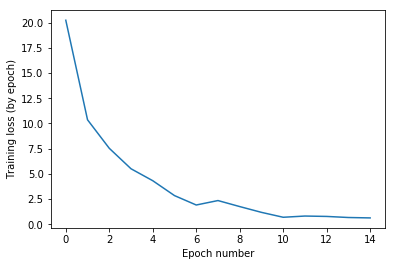

In [22]:
plt.plot(np.arange(len(ep_losses)), ep_losses)
plt.ylabel('Training loss (by epoch)')
plt.xlabel('Epoch number')

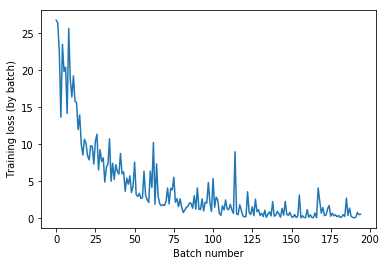

In [23]:
plt.plot(np.arange(len(it_losses)), it_losses)
plt.ylabel('Training loss (by batch)')
plt.xlabel('Batch number')

## Sample images

/Users/sanyam/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


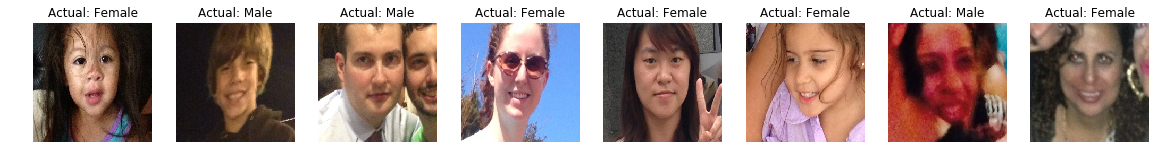

In [13]:
import matplotlib.pyplot as plt

def disp_images(samples, labels, predicted=False):
    labels = ['Female' if l==1 else 'Male' for l in label_nums]
    fig = plt.figure(figsize=(20, 10))
    for i, sample in enumerate(samples):
        a = fig.add_subplot(1,len(samples), i+1)
        plt.imshow(utils.load_image(sample).astype(np.uint8))
        if predicted:
            plt.title('Prediction: {}'.format(labels[i]))
        else:
            plt.title('Actual: {}'.format(labels[i]))
        plt.axis('off')

    
samples = list(fc7_train_loaded.keys())[50:58]
label_nums = [Y_train[np.where(X_train==s)][0] for s in samples]

disp_images(samples, label_nums)

## Predictions on specific images

In [24]:
tiny = 64

tf.reset_default_graph()

graph = tf.Graph()
with graph.as_default():
    
    # Create session
    sess = get_session(graph=graph)
    
    model = Classifier(params)
    init = tf.global_variables_initializer()
    with tf.device('/cpu:0'):    
        # Variable initializer
        sess.run(init)
        predictions = model.predict(session=sess, X=fc7_X_val[:tiny], Y=fc7_Y_val[:tiny])

[INFO] Classifying images


## Plotting the Confusion Matrix

Confusion matrix, without normalization
[[12 20]
 [15 17]]
Normalized confusion matrix
[[ 0.38  0.62]
 [ 0.47  0.53]]


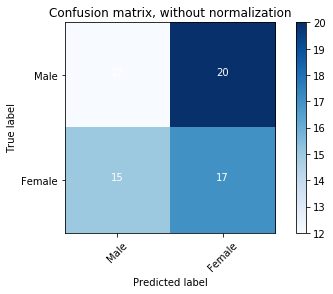

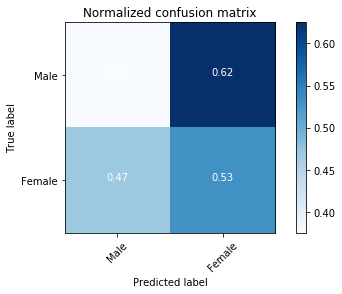

In [25]:
import itertools
from sklearn.metrics import confusion_matrix

"""
code snippet from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = list(zip(*predictions))[0]
y_true = list(zip(*predictions))[1]
class_names = ['Male', 'Female']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Hyperparameter search

In [37]:
"""
SMALL SEARCH
"""

lrs = [np.random.uniform()*1e-3,
       np.random.uniform()*1e-4,
       np.random.uniform()*1e-5]
bss = [32]
hds = [32, 64]
dos = [0.8, 1.0]

num_exps = len(bss)*len(hds)*len(dos)*len(lrs)
print(num_exps)

for lr in lrs:
    print('{:0.8f}'.format(lr))

12
0.00003970
0.00004508
0.00000348


In [31]:
"""
LARGE SEARCH
"""

lrs = [np.random.uniform()*1e-3, np.random.uniform()*1e-3,
       np.random.uniform()*1e-4, np.random.uniform()*1e-4,
       np.random.uniform()*1e-5, np.random.uniform()*1e-5]
bss = [16, 32]
hds = [32, 64, 96]
dos = [0.6, 1.0]

num_exps = len(bss)*len(hds)*len(dos)*len(lrs)
print(num_exps)

for lr in lrs:
    print('{:0.8f}'.format(lr))

72
0.00002827
0.00033838
0.00005851
0.00001384
0.00000046
0.00000648


In [38]:
params = set_params()
count = 0
tiny = 100
best_model, best_val_acc = None, float('-Inf')
for bs in bss:
    for hd in hds:
        for do in dos:
            for lr in lrs:
                count += 1
                print(10*'=')
                print('{} of {} experiments'.format(count, num_exps))
                print('\nLearning Rate: {}\nBatch Size: {}\nKeep Probs: {}\nHidden Dim: {}'.format(lr, bs, do, hd))
                print('[INFO] Best model val accuracy: {}'.format(best_val_acc))
                print(10*'=')
                params = set_params(lr, bs, do, hd)
                
                tf.reset_default_graph()

                graph = tf.Graph()
                with graph.as_default():

                    # Create session
                    sess = get_session(graph=graph)

                    model = Classifier(params)
                    init = tf.global_variables_initializer()
                    with tf.device('/cpu:0'):    
                        # Variable initializer
                        sess.run(init)
                        ep_losses, it_losses, b_val_acc, b_model = model.fit(session=sess, X=fc7_X_train, Y=fc7_Y_train, Xd=fc7_X_val, Yd=fc7_Y_val)
                        # ep_losses, it_losses, b_val_acc, b_model = model.fit(session=sess, X=fc7_X_train[:tiny], Y=fc7_Y_train[:tiny], Xd=fc7_X_val[:tiny//4], Yd=fc7_Y_val[:tiny//4])
                        if b_val_acc > best_val_acc:
                            best_val_acc = b_val_acc
                            best_model = b_model

TypeError: set_params() missing 4 required positional arguments: 'lr', 'bs', 'do', and 'hd'

In [33]:
print(best_val_acc)

72.8958630528


##### Note: The print statements are not consistent with the best val accuracy for the corresponding hyperparameters. There is a mismatch, it is off by 1 experiment

## Storing and restoring model

In [45]:
count = 0
tiny = 100
best_model, best_val_acc = None, float('-Inf')
for bs in bss:
    for hd in hds:
        for do in dos:
            for lr in lrs:
                count += 1
                print(10*'=')
                print('{} of {} experiments'.format(count, num_exps))
                print('\nLearning Rate: {}\nBatch Size: {}\nKeep Probs: {}\nHidden Dim: {}'.format(lr, bs, do, hd))
                print('[INFO] Best model val accuracy: {}'.format(best_val_acc))
                print(10*'=')
                params = set_params(lr, bs, do, hd)
                
                tf.reset_default_graph()

                graph = tf.Graph()
                with graph.as_default():

                    # Create session
                    sess = get_session(graph=graph)

                    model = Classifier(params)
                    init = tf.global_variables_initializer()
                    with tf.device('/cpu:0'):    
                        # Variable initializer
                        sess.run(init)
                        ep_losses, it_losses, b_val_acc, b_model = model.fit(session=sess, X=fc7_X_train, Y=fc7_Y_train, Xd=fc7_X_val, Yd=fc7_Y_val)
                        # ep_losses, it_losses, b_val_acc, b_model = model.fit(session=sess, X=fc7_X_train[:tiny], Y=fc7_Y_train[:tiny], Xd=fc7_X_val[:tiny//4], Yd=fc7_Y_val[:tiny//4])
                        if b_val_acc > best_val_acc:
                            best_val_acc = b_val_acc
                            best_model = b_model

1 of 12 experiments

Learning Rate: 3.969907010413587e-05
Batch Size: 32
Keep Probs: 0.8
Hidden Dim: 32
[INFO] Best model val accuracy: -inf
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 84.7	Accuracy = 43.4
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 1 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 1.1 and accuracy of 0.41
[INFO] Iteration 8: with minibatch training loss = 0.815 and accuracy of 0.5
[INFO] Iteration 16: with minibatch training loss = 1.04 and accuracy of 0.47
[INFO] Iteration 24: with minibatch training loss = 1.3 and accuracy of 0.31
[INFO] Iteration 32: with minibatch training loss = 0.855 and accuracy of 0.47
[INFO] Iteration 40: with minibatch training loss = 0.91 and accuracy of 0.47
[INFO] Iteration 48: with minibatch training loss = 0.745 and accuracy of 0.66
[INFO] Iteration 56: with minibatch training loss = 0.584 and accuracy of 0.72
[INFO] Itera

[INFO] Iteration 64: with minibatch training loss = 0.293 and accuracy of 0.91
[INFO] Iteration 72: with minibatch training loss = 0.277 and accuracy of 0.88
[INFO] Iteration 80: with minibatch training loss = 0.223 and accuracy of 0.97
[INFO] Iteration 88: with minibatch training loss = 0.238 and accuracy of 0.91
[INFO] Overall loss = 11.9	Accuracy = 83.6
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 9 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.491 and accuracy of 0.72
[INFO] Iteration 8: with minibatch training loss = 0.649 and accuracy of 0.69
[INFO] Iteration 16: with minibatch training loss = 0.31 and accuracy of 0.84
[INFO] Iteration 24: with minibatch training loss = 0.335 and accuracy of 0.91
[INFO] Iteration 32: with minibatch training loss = 0.399 and accuracy of 0.81
[INFO] Iteration 40: with minibatch training loss = 0.447 and accuracy of 0.78
[INFO] Iteration 48: with minibatch training loss

[INFO] Overall loss = 55	Accuracy = 69.8
2 of 12 experiments

Learning Rate: 4.5078758412377656e-05
Batch Size: 32
Keep Probs: 0.8
Hidden Dim: 32
[INFO] Best model val accuracy: 69.75748930099857
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 57.1	Accuracy = 45.1
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 1 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.748 and accuracy of 0.62
[INFO] Iteration 8: with minibatch training loss = 0.861 and accuracy of 0.53
[INFO] Iteration 16: with minibatch training loss = 0.888 and accuracy of 0.44
[INFO] Iteration 24: with minibatch training loss = 0.713 and accuracy of 0.59
[INFO] Iteration 32: with minibatch training loss = 0.644 and accuracy of 0.62
[INFO] Iteration 40: with minibatch training loss = 0.796 and accuracy of 0.59
[INFO] Iteration 48: with minibatch training loss = 0.673 and accuracy of 0.66
[INFO] Iteration 56: with min

[INFO] Iteration 32: with minibatch training loss = 0.225 and accuracy of 0.97
[INFO] Iteration 40: with minibatch training loss = 0.322 and accuracy of 0.91
[INFO] Iteration 48: with minibatch training loss = 0.413 and accuracy of 0.84
[INFO] Iteration 56: with minibatch training loss = 0.461 and accuracy of 0.84
[INFO] Iteration 64: with minibatch training loss = 0.288 and accuracy of 0.84
[INFO] Iteration 72: with minibatch training loss = 0.291 and accuracy of 0.94
[INFO] Iteration 80: with minibatch training loss = 0.253 and accuracy of 0.97
[INFO] Iteration 88: with minibatch training loss = 0.392 and accuracy of 0.91
[INFO] Overall loss = 11.7	Accuracy = 84.9
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 9 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.211 and accuracy of 0.94
[INFO] Iteration 8: with minibatch training loss = 0.406 and accuracy of 0.78
[INFO] Iteration 16: with minibatch training los

[INFO] Iteration 56: with minibatch training loss = 0.367 and accuracy of 0.91
[INFO] Iteration 64: with minibatch training loss = 0.501 and accuracy of 0.75
[INFO] Iteration 72: with minibatch training loss = 0.218 and accuracy of 0.91
[INFO] Iteration 80: with minibatch training loss = 0.359 and accuracy of 0.88
[INFO] Iteration 88: with minibatch training loss = 0.339 and accuracy of 0.84
[INFO] Overall loss = 9.14	Accuracy = 89
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 45.2	Accuracy = 67.5
3 of 12 experiments

Learning Rate: 3.4755678362164025e-06
Batch Size: 32
Keep Probs: 0.8
Hidden Dim: 32
[INFO] Best model val accuracy: 69.75748930099857
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 52.5	Accuracy = 47.9
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 1 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.808 and accuracy of 0.5
[INFO

[INFO] Iteration 16: with minibatch training loss = 0.574 and accuracy of 0.72
[INFO] Iteration 24: with minibatch training loss = 0.611 and accuracy of 0.69
[INFO] Iteration 32: with minibatch training loss = 0.707 and accuracy of 0.59
[INFO] Iteration 40: with minibatch training loss = 0.553 and accuracy of 0.69
[INFO] Iteration 48: with minibatch training loss = 0.647 and accuracy of 0.66
[INFO] Iteration 56: with minibatch training loss = 0.706 and accuracy of 0.62
[INFO] Iteration 64: with minibatch training loss = 0.672 and accuracy of 0.56
[INFO] Iteration 72: with minibatch training loss = 0.568 and accuracy of 0.75
[INFO] Iteration 80: with minibatch training loss = 0.623 and accuracy of 0.69
[INFO] Iteration 88: with minibatch training loss = 0.767 and accuracy of 0.59
[INFO] Overall loss = 19.9	Accuracy = 67
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 9 of 15 ====================
[INFO] Iteration 0: with minibatch training loss

[INFO] Iteration 72: with minibatch training loss = 0.479 and accuracy of 0.78
[INFO] Iteration 80: with minibatch training loss = 0.513 and accuracy of 0.72
[INFO] Iteration 88: with minibatch training loss = 0.408 and accuracy of 0.91
[INFO] Overall loss = 17.6	Accuracy = 72.7
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 56.3	Accuracy = 52.5
4 of 12 experiments

Learning Rate: 3.969907010413587e-05
Batch Size: 32
Keep Probs: 1.0
Hidden Dim: 32
[INFO] Best model val accuracy: 69.75748930099857
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 63.2	Accuracy = 42.4
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 1 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.719 and accuracy of 0.59
[INFO] Iteration 8: with minibatch training loss = 0.837 and accuracy of 0.69
[INFO] Iteration 16: with minibatch training loss = 0.551 and accuracy of 0.69
[INF

[INFO] Overall loss = 51.8	Accuracy = 64.6
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 8 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.357 and accuracy of 0.88
[INFO] Iteration 8: with minibatch training loss = 0.334 and accuracy of 0.84
[INFO] Iteration 16: with minibatch training loss = 0.27 and accuracy of 0.88
[INFO] Iteration 24: with minibatch training loss = 0.283 and accuracy of 0.91
[INFO] Iteration 32: with minibatch training loss = 0.23 and accuracy of 0.91
[INFO] Iteration 40: with minibatch training loss = 0.299 and accuracy of 0.88
[INFO] Iteration 48: with minibatch training loss = 0.449 and accuracy of 0.78
[INFO] Iteration 56: with minibatch training loss = 0.262 and accuracy of 0.88
[INFO] Iteration 64: with minibatch training loss = 0.474 and accuracy of 0.75
[INFO] Iteration 72: with minibatch training loss = 0.416 and accuracy of 0.84
[INFO] Iteration 80: with minibatch training loss 

[INFO] Iteration 40: with minibatch training loss = 0.432 and accuracy of 0.75
[INFO] Iteration 48: with minibatch training loss = 0.314 and accuracy of 0.88
[INFO] Iteration 56: with minibatch training loss = 0.22 and accuracy of 0.91
[INFO] Iteration 64: with minibatch training loss = 0.278 and accuracy of 0.94
[INFO] Iteration 72: with minibatch training loss = 0.192 and accuracy of 0.94
[INFO] Iteration 80: with minibatch training loss = 0.215 and accuracy of 0.94
[INFO] Iteration 88: with minibatch training loss = 0.222 and accuracy of 0.97
[INFO] Overall loss = 7.55	Accuracy = 91.8
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 51.2	Accuracy = 67.5
5 of 12 experiments

Learning Rate: 4.5078758412377656e-05
Batch Size: 32
Keep Probs: 1.0
Hidden Dim: 32
[INFO] Best model val accuracy: 69.75748930099857
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 55.9	Accuracy = 55.2
[INFO] ==================== TRAINING =======

[INFO] Iteration 72: with minibatch training loss = 0.304 and accuracy of 0.91
[INFO] Iteration 80: with minibatch training loss = 0.262 and accuracy of 0.91
[INFO] Iteration 88: with minibatch training loss = 0.204 and accuracy of 0.91
[INFO] Overall loss = 10.6	Accuracy = 86.3
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 46.9	Accuracy = 65.9
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 8 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.333 and accuracy of 0.81
[INFO] Iteration 8: with minibatch training loss = 0.39 and accuracy of 0.78
[INFO] Iteration 16: with minibatch training loss = 0.455 and accuracy of 0.81
[INFO] Iteration 24: with minibatch training loss = 0.233 and accuracy of 0.94
[INFO] Iteration 32: with minibatch training loss = 0.352 and accuracy of 0.84
[INFO] Iteration 40: with minibatch training loss = 0.359 and accuracy of 0.88
[INFO] Iteration 48: with

[INFO] Iteration 24: with minibatch training loss = 0.213 and accuracy of 0.94
[INFO] Iteration 32: with minibatch training loss = 0.187 and accuracy of 0.97
[INFO] Iteration 40: with minibatch training loss = 0.337 and accuracy of 0.81
[INFO] Iteration 48: with minibatch training loss = 0.223 and accuracy of 0.94
[INFO] Iteration 56: with minibatch training loss = 0.189 and accuracy of 0.97
[INFO] Iteration 64: with minibatch training loss = 0.201 and accuracy of 0.94
[INFO] Iteration 72: with minibatch training loss = 0.126 and accuracy of 1
[INFO] Iteration 80: with minibatch training loss = 0.292 and accuracy of 0.88
[INFO] Iteration 88: with minibatch training loss = 0.296 and accuracy of 0.84
[INFO] Overall loss = 7.17	Accuracy = 91.9
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 44.5	Accuracy = 69.6
6 of 12 experiments

Learning Rate: 3.4755678362164025e-06
Batch Size: 32
Keep Probs: 1.0
Hidden Dim: 32
[INFO] Best model val accuracy: 69.757489

[INFO] Iteration 16: with minibatch training loss = 0.565 and accuracy of 0.69
[INFO] Iteration 24: with minibatch training loss = 0.559 and accuracy of 0.66
[INFO] Iteration 32: with minibatch training loss = 0.58 and accuracy of 0.72
[INFO] Iteration 40: with minibatch training loss = 0.842 and accuracy of 0.34
[INFO] Iteration 48: with minibatch training loss = 0.568 and accuracy of 0.66
[INFO] Iteration 56: with minibatch training loss = 0.733 and accuracy of 0.59
[INFO] Iteration 64: with minibatch training loss = 0.504 and accuracy of 0.81
[INFO] Iteration 72: with minibatch training loss = 0.7 and accuracy of 0.56
[INFO] Iteration 80: with minibatch training loss = 0.679 and accuracy of 0.47
[INFO] Iteration 88: with minibatch training loss = 0.528 and accuracy of 0.66
[INFO] Overall loss = 20.4	Accuracy = 63
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 34	Accuracy = 59.2
[INFO] ==================== TRAINING ====================
[INFO] ======

[INFO] Iteration 16: with minibatch training loss = 0.436 and accuracy of 0.81
[INFO] Iteration 24: with minibatch training loss = 0.5 and accuracy of 0.72
[INFO] Iteration 32: with minibatch training loss = 0.66 and accuracy of 0.66
[INFO] Iteration 40: with minibatch training loss = 0.5 and accuracy of 0.72
[INFO] Iteration 48: with minibatch training loss = 0.566 and accuracy of 0.72
[INFO] Iteration 56: with minibatch training loss = 0.562 and accuracy of 0.66
[INFO] Iteration 64: with minibatch training loss = 0.714 and accuracy of 0.56
[INFO] Iteration 72: with minibatch training loss = 0.549 and accuracy of 0.72
[INFO] Iteration 80: with minibatch training loss = 0.602 and accuracy of 0.72
[INFO] Iteration 88: with minibatch training loss = 0.626 and accuracy of 0.69
[INFO] Overall loss = 17.2	Accuracy = 72.1
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 32.8	Accuracy = 64.6
7 of 12 experiments

Learning Rate: 3.969907010413587e-05
Batch Size:

[INFO] Iteration 32: with minibatch training loss = 0.223 and accuracy of 0.91
[INFO] Iteration 40: with minibatch training loss = 0.293 and accuracy of 0.91
[INFO] Iteration 48: with minibatch training loss = 0.575 and accuracy of 0.69
[INFO] Iteration 56: with minibatch training loss = 0.362 and accuracy of 0.84
[INFO] Iteration 64: with minibatch training loss = 0.261 and accuracy of 0.91
[INFO] Iteration 72: with minibatch training loss = 0.514 and accuracy of 0.81
[INFO] Iteration 80: with minibatch training loss = 0.558 and accuracy of 0.69
[INFO] Iteration 88: with minibatch training loss = 0.425 and accuracy of 0.88
[INFO] Overall loss = 11.4	Accuracy = 84.4
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 42.2	Accuracy = 71.9
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 8 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.33 and accuracy of 0.88
[INFO] Iteration 8: with

[INFO] Iteration 80: with minibatch training loss = 0.209 and accuracy of 0.91
[INFO] Iteration 88: with minibatch training loss = 0.323 and accuracy of 0.91
[INFO] Overall loss = 8.01	Accuracy = 89.6
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 15 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.138 and accuracy of 1
[INFO] Iteration 8: with minibatch training loss = 0.278 and accuracy of 0.91
[INFO] Iteration 16: with minibatch training loss = 0.182 and accuracy of 0.94
[INFO] Iteration 24: with minibatch training loss = 0.149 and accuracy of 0.97
[INFO] Iteration 32: with minibatch training loss = 0.229 and accuracy of 0.88
[INFO] Iteration 40: with minibatch training loss = 0.23 and accuracy of 0.94
[INFO] Iteration 48: with minibatch training loss = 0.287 and accuracy of 0.88
[INFO] Iteration 56: with minibatch training loss = 0.323 and accuracy of 0.88
[INFO] Iteration 64: with minibatch training loss =

[INFO] Iteration 64: with minibatch training loss = 0.38 and accuracy of 0.84
[INFO] Iteration 72: with minibatch training loss = 0.243 and accuracy of 0.88
[INFO] Iteration 80: with minibatch training loss = 0.387 and accuracy of 0.78
[INFO] Iteration 88: with minibatch training loss = 0.277 and accuracy of 0.88
[INFO] Overall loss = 11.7	Accuracy = 84.4
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 7 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.175 and accuracy of 0.97
[INFO] Iteration 8: with minibatch training loss = 0.476 and accuracy of 0.75
[INFO] Iteration 16: with minibatch training loss = 0.473 and accuracy of 0.88
[INFO] Iteration 24: with minibatch training loss = 0.455 and accuracy of 0.84
[INFO] Iteration 32: with minibatch training loss = 0.497 and accuracy of 0.78
[INFO] Iteration 40: with minibatch training loss = 0.221 and accuracy of 0.94
[INFO] Iteration 48: with minibatch training loss

[INFO] Iteration 16: with minibatch training loss = 0.228 and accuracy of 0.91
[INFO] Iteration 24: with minibatch training loss = 0.181 and accuracy of 0.91
[INFO] Iteration 32: with minibatch training loss = 0.278 and accuracy of 0.88
[INFO] Iteration 40: with minibatch training loss = 0.35 and accuracy of 0.84
[INFO] Iteration 48: with minibatch training loss = 0.217 and accuracy of 0.91
[INFO] Iteration 56: with minibatch training loss = 0.226 and accuracy of 0.91
[INFO] Iteration 64: with minibatch training loss = 0.5 and accuracy of 0.81
[INFO] Iteration 72: with minibatch training loss = 0.136 and accuracy of 0.97
[INFO] Iteration 80: with minibatch training loss = 0.218 and accuracy of 0.94
[INFO] Iteration 88: with minibatch training loss = 0.201 and accuracy of 0.94
[INFO] Overall loss = 7.22	Accuracy = 91.9
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 15 of 15 ====================
[INFO] Iteration 0: with minibatch training loss

[INFO] Iteration 16: with minibatch training loss = 0.822 and accuracy of 0.56
[INFO] Iteration 24: with minibatch training loss = 0.8 and accuracy of 0.59
[INFO] Iteration 32: with minibatch training loss = 0.78 and accuracy of 0.66
[INFO] Iteration 40: with minibatch training loss = 0.664 and accuracy of 0.56
[INFO] Iteration 48: with minibatch training loss = 0.788 and accuracy of 0.41
[INFO] Iteration 56: with minibatch training loss = 0.744 and accuracy of 0.62
[INFO] Iteration 64: with minibatch training loss = 0.614 and accuracy of 0.69
[INFO] Iteration 72: with minibatch training loss = 0.652 and accuracy of 0.66
[INFO] Iteration 80: with minibatch training loss = 0.673 and accuracy of 0.59
[INFO] Iteration 88: with minibatch training loss = 0.779 and accuracy of 0.59
[INFO] Overall loss = 23.6	Accuracy = 57.7
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 7 of 15 ====================
[INFO] Iteration 0: with minibatch training loss 

[INFO] Iteration 72: with minibatch training loss = 0.385 and accuracy of 0.84
[INFO] Iteration 80: with minibatch training loss = 0.527 and accuracy of 0.75
[INFO] Iteration 88: with minibatch training loss = 0.754 and accuracy of 0.47
[INFO] Overall loss = 19.1	Accuracy = 68.8
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 44.8	Accuracy = 62.1
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 14 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.513 and accuracy of 0.72
[INFO] Iteration 8: with minibatch training loss = 0.578 and accuracy of 0.69
[INFO] Iteration 16: with minibatch training loss = 0.526 and accuracy of 0.81
[INFO] Iteration 24: with minibatch training loss = 0.484 and accuracy of 0.78
[INFO] Iteration 32: with minibatch training loss = 0.702 and accuracy of 0.62
[INFO] Iteration 40: with minibatch training loss = 0.559 and accuracy of 0.66
[INFO] Iteration 48: wi

[INFO] Iteration 56: with minibatch training loss = 0.539 and accuracy of 0.78
[INFO] Iteration 64: with minibatch training loss = 0.863 and accuracy of 0.72
[INFO] Iteration 72: with minibatch training loss = 0.296 and accuracy of 0.88
[INFO] Iteration 80: with minibatch training loss = 0.846 and accuracy of 0.75
[INFO] Iteration 88: with minibatch training loss = 0.647 and accuracy of 0.75
[INFO] Overall loss = 14.3	Accuracy = 81.8
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 128	Accuracy = 46.5
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 6 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.551 and accuracy of 0.88
[INFO] Iteration 8: with minibatch training loss = 0.298 and accuracy of 0.88
[INFO] Iteration 16: with minibatch training loss = 0.566 and accuracy of 0.75
[INFO] Iteration 24: with minibatch training loss = 0.671 and accuracy of 0.72
[INFO] Iteration 32: with

[INFO] Iteration 8: with minibatch training loss = 0.15 and accuracy of 1
[INFO] Iteration 16: with minibatch training loss = 0.304 and accuracy of 0.88
[INFO] Iteration 24: with minibatch training loss = 0.188 and accuracy of 0.94
[INFO] Iteration 32: with minibatch training loss = 0.24 and accuracy of 0.94
[INFO] Iteration 40: with minibatch training loss = 0.199 and accuracy of 0.94
[INFO] Iteration 48: with minibatch training loss = 0.163 and accuracy of 1
[INFO] Iteration 56: with minibatch training loss = 0.408 and accuracy of 0.84
[INFO] Iteration 64: with minibatch training loss = 0.18 and accuracy of 0.97
[INFO] Iteration 72: with minibatch training loss = 0.244 and accuracy of 0.88
[INFO] Iteration 80: with minibatch training loss = 0.254 and accuracy of 0.88
[INFO] Iteration 88: with minibatch training loss = 0.21 and accuracy of 0.97
[INFO] Overall loss = 8.3	Accuracy = 90.7
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 75.3	Accuracy = 61

[INFO] Iteration 56: with minibatch training loss = 0.347 and accuracy of 0.88
[INFO] Iteration 64: with minibatch training loss = 0.373 and accuracy of 0.81
[INFO] Iteration 72: with minibatch training loss = 0.235 and accuracy of 0.88
[INFO] Iteration 80: with minibatch training loss = 0.494 and accuracy of 0.66
[INFO] Iteration 88: with minibatch training loss = 0.306 and accuracy of 0.94
[INFO] Overall loss = 10.7	Accuracy = 86.4
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 52.5	Accuracy = 66.5
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 6 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.262 and accuracy of 0.88
[INFO] Iteration 8: with minibatch training loss = 0.326 and accuracy of 0.84
[INFO] Iteration 16: with minibatch training loss = 0.233 and accuracy of 0.94
[INFO] Iteration 24: with minibatch training loss = 0.368 and accuracy of 0.81
[INFO] Iteration 32: wit

[INFO] Iteration 8: with minibatch training loss = 0.209 and accuracy of 0.94
[INFO] Iteration 16: with minibatch training loss = 0.186 and accuracy of 0.97
[INFO] Iteration 24: with minibatch training loss = 0.178 and accuracy of 0.91
[INFO] Iteration 32: with minibatch training loss = 0.215 and accuracy of 0.91
[INFO] Iteration 40: with minibatch training loss = 0.145 and accuracy of 0.94
[INFO] Iteration 48: with minibatch training loss = 0.241 and accuracy of 0.88
[INFO] Iteration 56: with minibatch training loss = 0.27 and accuracy of 0.84
[INFO] Iteration 64: with minibatch training loss = 0.18 and accuracy of 0.91
[INFO] Iteration 72: with minibatch training loss = 0.162 and accuracy of 0.97
[INFO] Iteration 80: with minibatch training loss = 0.175 and accuracy of 0.94
[INFO] Iteration 88: with minibatch training loss = 0.212 and accuracy of 0.88
[INFO] Overall loss = 6.57	Accuracy = 92.7
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 54.3	Accu

[INFO] Iteration 64: with minibatch training loss = 0.852 and accuracy of 0.59
[INFO] Iteration 72: with minibatch training loss = 0.692 and accuracy of 0.66
[INFO] Iteration 80: with minibatch training loss = 0.65 and accuracy of 0.69
[INFO] Iteration 88: with minibatch training loss = 0.649 and accuracy of 0.69
[INFO] Overall loss = 21.9	Accuracy = 63
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 84.8	Accuracy = 47.5
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 6 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.777 and accuracy of 0.53
[INFO] Iteration 8: with minibatch training loss = 0.648 and accuracy of 0.69
[INFO] Iteration 16: with minibatch training loss = 0.751 and accuracy of 0.53
[INFO] Iteration 24: with minibatch training loss = 0.522 and accuracy of 0.78
[INFO] Iteration 32: with minibatch training loss = 0.677 and accuracy of 0.62
[INFO] Iteration 40: with m

[INFO] Iteration 32: with minibatch training loss = 0.451 and accuracy of 0.75
[INFO] Iteration 40: with minibatch training loss = 0.638 and accuracy of 0.62
[INFO] Iteration 48: with minibatch training loss = 0.375 and accuracy of 0.72
[INFO] Iteration 56: with minibatch training loss = 0.299 and accuracy of 0.88
[INFO] Iteration 64: with minibatch training loss = 0.689 and accuracy of 0.69
[INFO] Iteration 72: with minibatch training loss = 0.328 and accuracy of 0.88
[INFO] Iteration 80: with minibatch training loss = 0.622 and accuracy of 0.59
[INFO] Iteration 88: with minibatch training loss = 0.696 and accuracy of 0.66
[INFO] Overall loss = 16.8	Accuracy = 73.6
[INFO] ==================== VALIDATION ====================
[INFO] Overall loss = 81.2	Accuracy = 50.6
[INFO] ==================== TRAINING ====================
[INFO] ==================== Epoch 14 of 15 ====================
[INFO] Iteration 0: with minibatch training loss = 0.401 and accuracy of 0.81
[INFO] Iteration 8: wi

In [46]:
print(best_val_acc)

72.8958630528


In [47]:
save_path = './saved_model/best_model.ckpt'
best_model.save_model(sess, save_path)

[INFO] Saving the model to: ./saved_model/best_model.ckpt


In [ ]:
params = set_params(lr, bs, do, hd)

tf.reset_default_graph()

    graph = tf.Graph()
    with graph.as_default():

        # Create session
        sess = get_session(graph=graph)

        new_model = Classifier(params)
        init = tf.global_variables_initializer()
        new_model.restore_model()
        # TODO: